## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib
from PIL import Image
import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
from transformers import TFAutoModel
import shutil
from zipfile import ZipFile
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, ViTForImageClassification, AutoImageProcessor, ConvNextForImageClassification, AutoModelForImageClassification
import torch
from torch.utils.data import DataLoader
try:
  from datasets import load_dataset
except:
  !pip install datasets
  from datasets import load_dataset
try:
  import evaluate
except:
  !pip install evaluate
  import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00


## Downloading the Data

In [ ]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/buy-sell-object-detection-dataset")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 122M/122M [00:07<00:00, 17.7MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Getting the data ready for the machine learning model

In [ ]:
def get_folder_length(directory):
  """
  Get the number of items in a specific folder.
  :param directory: Path to the folder
  :return: Number of items in the folder
  """
  if not os.path.exists(directory):
      raise FileNotFoundError(f"The directory '{directory}' does not exist.")

  return len(os.listdir(directory))

In [ ]:
def split_and_rename_data(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Splits and renames data from `input_dir` into train, validation, and test folders.

    Parameters:
    - input_dir: Path to the input directory containing `buy` and `sell` folders.
    - output_dir: Path to the output directory where the split data will be saved.
    - train_ratio: Proportion of data for training.
    - val_ratio: Proportion of data for validation.
    - test_ratio: Proportion of data for testing.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Define subdirectories for buy and sell
    classes = ['buy', 'sell']

    for class_name in classes:
        class_dir = os.path.join(input_dir, class_name)

        # Get all subfolders in the class directory
        subfolders = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, f))]

        # Shuffle subfolders randomly
        random.shuffle(subfolders)

        # Compute split indices
        train_count = int(len(subfolders) * train_ratio)
        val_count = int(len(subfolders) * val_ratio)

        train_folders = subfolders[:train_count]
        val_folders = subfolders[train_count:train_count + val_count]
        test_folders = subfolders[train_count + val_count:]

        # Create output subdirectories
        for split, split_folders in zip(['train', 'validation', 'test'], [train_folders, val_folders, test_folders]):
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            # Process each folder in the split
            for folder in split_folders:
                folder_name = os.path.basename(folder)  # Get the folder name
                historical_chart_path = os.path.join(folder, "historical_chart.png")

                if os.path.exists(historical_chart_path):
                    # Rename the file to <foldername>.png
                    new_file_name = f"{folder_name}.png"
                    new_file_path = os.path.join(split_class_dir, new_file_name)

                    # Copy the file to the destination
                    shutil.copy(historical_chart_path, new_file_path)
                else:
                    print(f"Warning: {historical_chart_path} not found in {folder}")

    print(f"Data successfully split into {output_dir}/train, {output_dir}/validation, and {output_dir}/test")

In [ ]:
# Example usage
input_dir = '/content/output_latest.zip/candlestick_charts'  # Path to the input directory with `buy` and `sell` folders
output_dir = '/content/output_folder'  # Path to the output directory
split_and_rename_data(input_dir, output_dir)

Data successfully split into /content/output_folder/train, /content/output_folder/validation, and /content/output_folder/test


In [ ]:
folder_path = "/content/output_folder/validation/sell"

folder_length = get_folder_length(folder_path)
print(f"The folder '{folder_path}' contains {folder_length} items.")

The folder '/content/output_folder/validation/sell' contains 803 items.


In [ ]:
def display_matching_charts(test_image_path=None, candlestick_charts_dir="/content/output_latest.zip/candlestick_charts", output_folder="/content/output_folder"):
    """
    Displays a randomly selected test image and its corresponding full chart if no test_image_path is provided.
    If a test_image_path is provided, it retrieves and displays the test image alongside the full chart.

    Parameters:
    - test_image_path: Path to the test image (e.g., /content/output_folder/test/buy/AUDCAD_sequence_12255.png). If None, a random image is selected.
    - candlestick_charts_dir: Path to the candlestick charts directory (e.g., /content/output_latest.zip/candlestick_charts).
    - output_folder: Path to the folder containing train, validation, and test splits.
    """
    # Select a random test image if test_image_path is not provided
    if test_image_path is None:
        test_subfolders = ['train', 'validation', 'test']
        selected_split = random.choice(test_subfolders)
        random_class_folder = random.choice(['buy', 'sell'])
        random_class_path = os.path.join(output_folder, selected_split, random_class_folder)

        if not os.path.exists(random_class_path) or len(os.listdir(random_class_path)) == 0:
            print(f"Error: No images found in {random_class_path}")
            return

        test_image_path = os.path.join(random_class_path, random.choice(os.listdir(random_class_path)))

    # Determine whether the image is "buy" or "sell"
    parent_folder = os.path.basename(os.path.dirname(test_image_path))  # Get parent folder name ('buy' or 'sell')

    # Extract folder name from the test image path
    folder_name = os.path.basename(test_image_path).replace('.png', '')

    # Find the corresponding folder in the candlestick charts directory
    matching_folder_path = None
    for class_folder in ['buy', 'sell']:
        search_path = os.path.join(candlestick_charts_dir, class_folder)
        potential_folder = os.path.join(search_path, folder_name)
        if os.path.exists(potential_folder):
            matching_folder_path = potential_folder
            break

    if matching_folder_path is None:
        print(f"Error: Folder '{folder_name}' not found in {candlestick_charts_dir}.")
        return

    # Retrieve the `full_chart.png` from the matching folder
    full_chart_path = os.path.join(matching_folder_path, 'full_chart.png')
    if not os.path.exists(full_chart_path):
        print(f"Error: full_chart.png not found in folder '{matching_folder_path}'.")
        return

    # Open and display both images
    try:
        # Open test image
        test_image = Image.open(test_image_path)

        # Open full chart image
        full_chart = Image.open(full_chart_path)

        # Plot the images side by side
        plt.figure(figsize=(10, 5))

        # Display the test image
        plt.subplot(1, 2, 1)
        plt.title(f"Test Image ({parent_folder}): {os.path.basename(test_image_path)}")
        plt.imshow(test_image)
        plt.axis('off')

        # Display the full chart
        plt.subplot(1, 2, 2)
        plt.title("Full Chart")
        plt.imshow(full_chart)
        plt.axis('off')

        # Show the plots
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error displaying images: {e}")

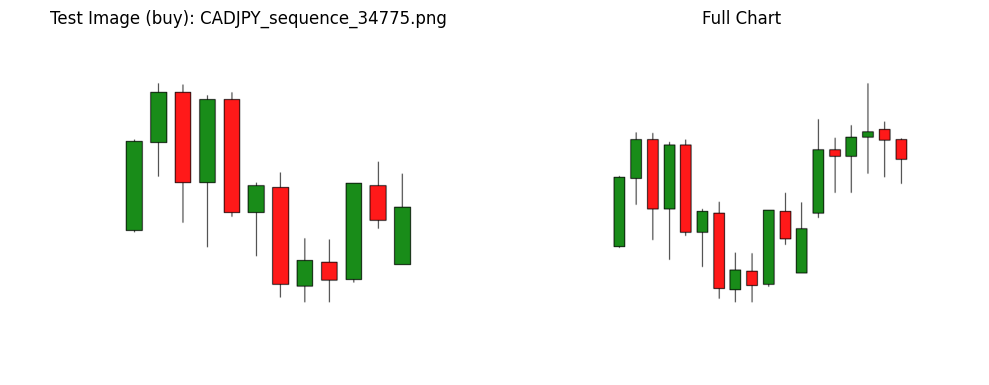

In [ ]:
# Example usage
candlestick_charts_dir = "/content/output_latest.zip/candlestick_charts"
output_folder = "/content/output_folder"
# If test_image_path is None, a random image will be selected
display_matching_charts(test_image_path=None, candlestick_charts_dir=candlestick_charts_dir, output_folder=output_folder)

In [ ]:
model_name = 'facebook/convnext-base-224'

In [ ]:
# Define compute_metrics function
def compute_metrics(eval_pred):
    """
    Compute accuracy metrics for evaluation.
    """
    logits, labels = eval_pred
    # Convert logits to predictions (class indices)
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    # labels are already numpy arrays
    return {"accuracy": (predictions == labels).mean()}

In [ ]:
# Define preprocessing function
def preprocess_images(examples):
    """
    Preprocess images for the image processor and include image filenames.
    """
    if 'image_path' not in examples:
        raise KeyError("The 'image_path' key is missing in the dataset examples.")

    # Convert images from file paths to tensors and preprocess using the image processor
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    inputs = image_processor(images, return_tensors="pt")

    # Add labels
    inputs['label'] = examples['label']

    # Add image paths
    inputs['image_path'] = examples['image_path']

    return inputs

In [ ]:
# Define a collate function
def collate_fn(batch):
    """
    Collate function for DataLoader.
    Stacks pixel values and labels into batches.
    """
    pixel_values = torch.stack([x['pixel_values'] for x in batch])
    labels = torch.tensor([x['label'] for x in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
# Load dataset from folder structure
dataset = load_dataset('imagefolder', data_dir='/content/output_folder')

# Add image paths to the dataset
def add_image_paths(example, split):
    """
    Add the correct file paths to the dataset for each example.
    """
    # Get the root directory for the split (train, validation, or test)
    root_dir = f"output_folder/{split}"

    # Extract the class folder name
    class_folder = dataset[split].features['label'].names[example['label']]

    # Construct the full file path using the image filename (already relative)
    example['image_path'] = f"{root_dir}/{class_folder}/{os.path.basename(example['image'].filename)}"
    return example

# Add image paths for each split in the dataset
for split in dataset.keys():
    dataset[split] = dataset[split].map(
        lambda example: add_image_paths(example, split),
        keep_in_memory=True
    )

# Verify the structure of the dataset
print(dataset['train'][0])  # Print the first example to check the 'image_path'
print(dataset['train'].features)

# Extract class names
class_names = dataset['train'].features['label'].names
print(f"Class names: {class_names}")

# Load a pretrained image processor
image_processor = AutoImageProcessor.from_pretrained(model_name)  # Updated to AutoImageProcessor

# Apply preprocessing to the dataset
dataset = dataset.with_transform(preprocess_images)

Resolving data files:   0%|          | 0/13012 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1626 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1628 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/13012 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

Map:   0%|          | 0/1628 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x575 at 0x786626D39870>, 'label': 0, 'image_path': 'output_folder/train/buy/AUDCAD_sequence_10214.png'}
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['buy', 'sell'], id=None), 'image_path': Value(dtype='string', id=None)}
Class names: ['buy', 'sell']


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [ ]:
dataset['validation'][0]

{'pixel_values': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.640

In [ ]:
len(dataset['train']), len(dataset['validation']), len(dataset['test'])

(13012, 1626, 1628)

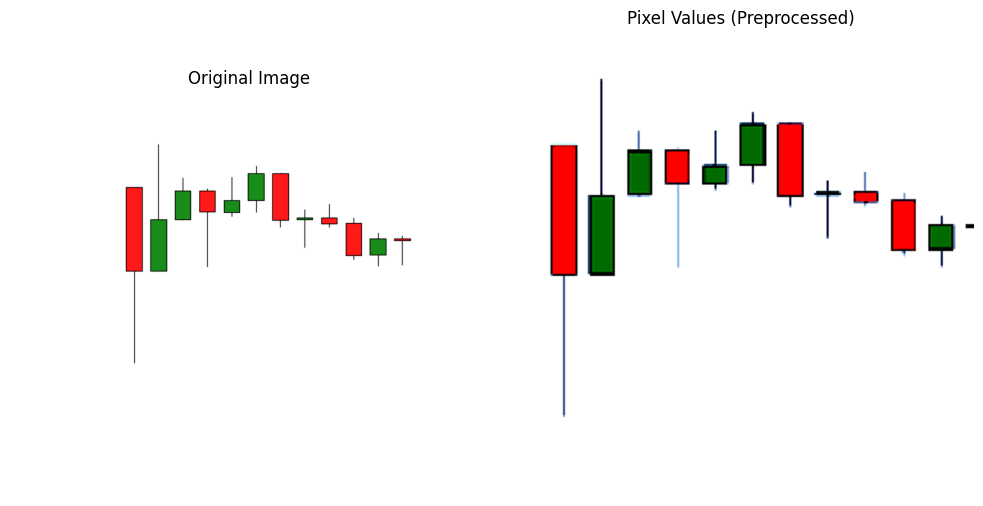

In [ ]:
def plot_image_and_pixel_values_fixed(example):
    """
    Plot the original image (from image_path) and the pixel values tensor side by side,
    ensuring consistent visualization.
    """
    pixel_values = example['pixel_values']
    image_path = example['image_path']

    # Convert pixel values to a numpy array for visualization
    if isinstance(pixel_values, torch.Tensor):
        pixel_values_np = pixel_values.permute(1, 2, 0).numpy()  # Convert to HWC format
    else:
        pixel_values_np = np.array(pixel_values)

    # Ensure pixel values are clipped between 0 and 1
    pixel_values_np = np.clip(pixel_values_np, 0, 1)

    # Open the original image using its path
    original_image = Image.open(image_path)

    # Plot the original image and pixel values side by side
    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot the normalized pixel values
    plt.subplot(1, 2, 2)
    plt.imshow(pixel_values_np)
    plt.title("Pixel Values (Preprocessed)")
    plt.axis('off')

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function with a random example
plot_image_and_pixel_values_fixed(random.choice(dataset['train']))

In [ ]:
def count_missing_image_paths(dataset_split):
    """
    Counts the number of examples in the dataset split that are missing `image_path`
    or have `image_path` set to None.
    """
    missing_count = 0
    for example in dataset_split:
        if 'image_path' not in example or example['image_path'] is None:
            missing_count += 1
    return missing_count

# Count missing `image_path` in train and validation datasets
missing_train = count_missing_image_paths(dataset['train'])
missing_validation = count_missing_image_paths(dataset['validation'])
missing_test = count_missing_image_paths(dataset['test'])

print(f"Number of examples missing 'image_path' in train dataset: {missing_train}")
print(f"Number of examples missing 'image_path' in validation dataset: {missing_validation}")
print(f"Number of examples missing 'image_path' in validation dataset: {missing_test}")

Number of examples missing 'image_path' in train dataset: 0
Number of examples missing 'image_path' in validation dataset: 0
Number of examples missing 'image_path' in validation dataset: 0


## Training model

In [ ]:
# Load pretrained model for image classification
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    id2label={i: label for i, label in enumerate(class_names)},
    label2id={label: i for i, label in enumerate(class_names)},
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_dir='./logs',
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"
)

# Load the accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Add EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Update Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],  # Pass dataset directly
    eval_dataset=dataset['validation'],
    data_collator=collate_fn,  # Use custom collate function
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained('./saved_model')
image_processor.save_pretrained('./saved_model')  # Save processor

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.586300,0.619861,0.635916
2,0.629600,0.605893,0.640221
3,0.551100,0.601869,0.651292
4,0.529800,0.607895,0.648831
5,0.483100,0.630446,0.652522


['./saved_model/preprocessor_config.json']

In [ ]:
# Evaluate on the test set
metrics = trainer.evaluate(dataset['test'])
print(f"Test Accuracy: {metrics['eval_accuracy']:.4f}")

Test Accuracy: 0.6407


## Load model and make prediction

Model and processor successfully loaded.
Class mappings: {0: 'buy', 1: 'sell'}


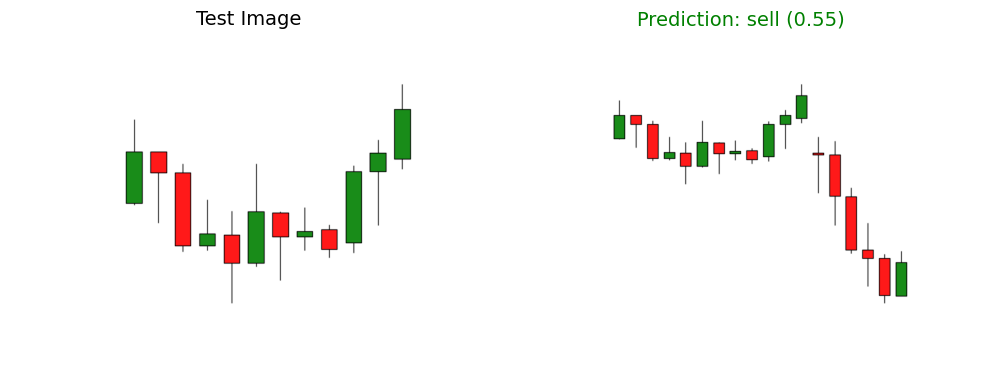

In [ ]:
import os
import random
from transformers import AutoModelForImageClassification, AutoImageProcessor
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
saved_model_path = './saved_model'
test_image_base_path = '/content/output_folder/test'
candlestick_charts_path = '/content/output_latest.zip/candlestick_charts'

# Load the saved model
model = AutoModelForImageClassification.from_pretrained(saved_model_path)

# Load the saved processor
image_processor = AutoImageProcessor.from_pretrained(saved_model_path)

# Load class mappings
id2label = model.config.id2label
label2id = model.config.label2id

print(f"Model and processor successfully loaded.")
print(f"Class mappings: {id2label}")

def predict(image_path):
    """
    Predict the class of an image using the loaded model.
    Args:
        image_path (str): Path to the input image.
    Returns:
        dict: Predicted class and confidence score.
    """
    # Open the image
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image
    inputs = image_processor(images=image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class_idx = torch.argmax(probabilities).item()
        predicted_class = id2label[predicted_class_idx]
        confidence = probabilities[0, predicted_class_idx].item()

    return {"class": predicted_class, "confidence": confidence}

def visualize_prediction():
    """
    Choose a random test image, predict its class, and display the results.
    """
    # Choose a random image from test folder
    random_class = random.choice(['buy', 'sell'])
    class_folder = os.path.join(test_image_base_path, random_class)
    random_image_name = random.choice(os.listdir(class_folder))
    test_image_path = os.path.join(class_folder, random_image_name)

    # Perform prediction
    prediction = predict(test_image_path)
    predicted_class = prediction['class']
    confidence = prediction['confidence']

    # Extract folder name from the image name
    folder_name = os.path.splitext(os.path.basename(test_image_path))[0]

    # Find the corresponding folder in candlestick charts
    corresponding_folder = os.path.join(candlestick_charts_path, random_class, folder_name)
    full_chart_path = os.path.join(corresponding_folder, 'full_chart.png')

    # Check if the full chart exists
    if not os.path.exists(full_chart_path):
        print(f"Full chart not found for {folder_name}.")
        return

    # Load images for visualization
    original_image = Image.open(test_image_path)
    full_chart_image = Image.open(full_chart_path)

    # Set title color based on correct/incorrect prediction
    title_color = 'green' if random_class == predicted_class else 'red'

    # Plot the images side by side
    plt.figure(figsize=(10, 5))

    # Plot the test image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Test Image", fontsize=14)
    plt.axis('off')

    # Plot the full chart image
    plt.subplot(1, 2, 2)
    plt.imshow(full_chart_image)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})", fontsize=14, color=title_color)
    plt.axis('off')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_prediction()